# Medical image analysis based on GMM

we will apply GMM to find the distribution of colors in medical images.

In [1]:
import os
import scipy
import tqdm
from PIL import Image
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [2]:
# https://www.kaggle.com/datasets/saife245/tuberculosis-image-datasets
path_to_download = "data/MED"

## Parse data

In [3]:
def load_jpg(path):
    image = Image.open(path)
    return np.array(image)
def load_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()
    # Accessing object details
    
    data = []
    for obj in root.findall("object"):
        label = obj.find("label").text
        pose = obj.find("pose").text
        truncated = obj.find("truncated").text
        occluded = obj.find("occluded").text
        
        # Access bounding box details
        bndbox = obj.find("bndbox")
        xmin = bndbox.find("xmin").text
        ymin = bndbox.find("ymin").text
        xmax = bndbox.find("xmax").text
        ymax = bndbox.find("ymax").text
    
        data.append((xmin,xmax,ymin,ymax, label))
    return data
def get_data(path):
    file_names = os.listdir(path)
    data_jpg = {}
    data_xml = {}
    labels = set()
    for file_name in file_names:
        file_path = os.path.join(path, file_name)
        file_without_ext = file_name.split('.')[0]
        if file_name.endswith(".jpg"):
            data_jpg[file_without_ext] = load_jpg(file_path)
        
        if file_name.endswith(".xml"):
            data_xml[file_without_ext] = load_xml(file_path)
        assert True, "Not supported format found in the directory"
    
    keys = list(data_jpg.keys())
    x = []
    y = []
    for key in keys:
        x.append(data_jpg[key])
        y.append(data_xml[key])
    return x, y, keys
    
    
x,y, file_name = get_data(path_to_download)


In [4]:
def get_labelled_pixel(x,y):
    
    tuberculosis_pixelled = []  # Tuberculosis pixels
    non_tuberculosis_pixelled = []  # Non-tuberculosis pixels
     
    for img, boxes in tqdm.tqdm(list(zip(x, y))):
        # Initialize masks for tuberculosis and non-tuberculosis pixels
        mask_tuberculosis = np.zeros(img.shape[:2], dtype=bool)  # Binary mask for tuberculosis regions

        for box in boxes:
            xmin, xmax, ymin, ymax, label = box 
            mask_tuberculosis[int(xmin):int(xmax), int(ymin):int(ymax)] = True 
        
        # Extract tuberculosis pixels
        tuberculosis_pixels = img[mask_tuberculosis].reshape(-1,3)
        tuberculosis_pixelled.append(tuberculosis_pixels)

        # Extract non-tuberculosis pixels
        mask_non_tuberculosis = ~mask_tuberculosis
        non_tuberculosis_pixels = img[mask_non_tuberculosis].reshape(-1,3)
        non_tuberculosis_pixelled.append(non_tuberculosis_pixels)
    
    tuberculosis_pixels_flat = np.concatenate(tuberculosis_pixelled, axis=0)  # All tuberculosis pixels in one array
    normal_pixels_flat = np.concatenate(non_tuberculosis_pixelled, axis=0)  # All normal pixels in one array
    
    # Generate labels
    y_tuberculosis = np.ones(tuberculosis_pixels_flat.shape[0])  # Label 1 for tuberculosis
    y_normal = np.zeros(normal_pixels_flat.shape[0])  # Label 0 for normal

    # Concatenate data and labels
    X = np.concatenate([tuberculosis_pixels_flat, normal_pixels_flat], axis=0)  # Combine all pixels
    y = np.concatenate([y_tuberculosis, y_normal], axis=0)  # Combine all labels
    
    # Shuffle the dataset
    print("suffling")
    indices = np.random.permutation(X.shape[0])  # Generate a random permutation of indices
    X = X[indices]  # Shuffle X
    y = y[indices]  # Shuffle y to match X
    
    return X, y

        

In [5]:
 X_pixelled, y_pixelled = get_labelled_pixel(x[:100],y[:100])


100%|██████████| 100/100 [00:02<00:00, 43.54it/s]


suffling


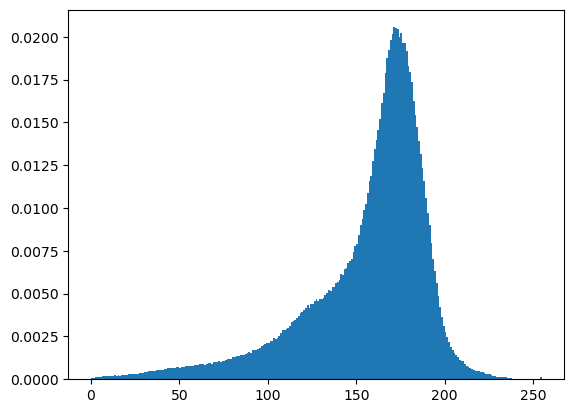

In [12]:
nb_data_considered= int(1e6)
nb_data_test = int(1e4)
x_train,x_test = X_pixelled[:nb_data_considered], X_pixelled[nb_data_considered:nb_data_considered + nb_data_test]
y_train, y_test = y_pixelled[:nb_data_considered], y_pixelled[nb_data_considered:nb_data_considered+ nb_data_test]
plt.hist(x_train[:,0], bins=255, density=True)
plt.show()

In [13]:
from GDA import GDA

model = GDA(5)
model.fit(x_train, y_train)

## Study GDA

In [14]:
def print_metrics(y_val_pred,y_val):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

    # Assuming y_val_pred contains predictions and y_val contains true labels
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, average='weighted')
    recall = recall_score(y_val, y_val_pred, average='weighted')
    f1 = f1_score(y_val, y_val_pred, average='weighted')
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    
    print("Accuracy:", accuracy)
    print("Precision (Weighted):", precision)
    print("Recall (Weighted):", recall)
    print("F1-Score (Weighted):", f1)
    print("\nConfusion Matrix:\n", conf_matrix)
    
    # Detailed classification report
    print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
    
nb_considered = int(1e5)
y_test_pred = model.predict(x_test)
print_metrics(y_test_pred,y_test)

Accuracy: 0.4484
Precision (Weighted): 0.9713974324845153
Recall (Weighted): 0.4484
F1-Score (Weighted): 0.606143290204265

Confusion Matrix:
 [[4401 5452]
 [  64   83]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.45      0.61      9853
         1.0       0.01      0.56      0.03       147

    accuracy                           0.45     10000
   macro avg       0.50      0.51      0.32     10000
weighted avg       0.97      0.45      0.61     10000



In [9]:
def transform_img(img, trained_model):
    img_shape = img.shape
    img_pixeled = img.reshape(-1,3)
    classes = trained_model.predict(img_pixeled)
    predicted_pixeled = trained_model.means_[classes]
    img_pred = predicted_pixeled.reshape(img_shape)
    return img_pred

def add_labels(boxes, ax):
    for box in boxes:
        xmin,xmax,ymin,ymax, _ = box
        xmin,xmax,ymin,ymax = int(xmin),int(xmax),int(ymin),int(ymax)
        rectangle = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                         linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rectangle)
        
        
img_0 = x[0]
result = transform_img(img_0, model)
result = np.rint(result).astype(np.uint8)
fix,ax = plt.subplots(2,1)
add_labels(y[0], ax[0])
ax[0].imshow(img_0)
ax[1].imshow(result)
print(img_0.shape)
    

AttributeError: 'GDA' object has no attribute 'means_'

In [1]:
img_0 = x[0]
result = transform_img(img_0, model)
result = np.rint(result).astype(np.uint8)
nb_box = len(y[0])
fix,ax = plt.subplots(2,nb_box)
for k,box in enumerate(y[0]):
    xmin,xmax,ymin,ymax, _ = box
    xmin,xmax,ymin,ymax = int(xmin),int(xmax),int(ymin),int(ymax)
    xmin, ymin = max(0, xmin), max(0, ymin)
    xmax, ymax = min(img_0.shape[1], xmax), min(img_0.shape[0], ymax)
    print(xmin,xmax,ymin,ymax)
    ax[0][k].imshow(img_0[ymin:ymax, xmin:xmax])
    ax[1][k].imshow(result[ymin:ymax, xmin:xmax])
    

NameError: name 'x' is not defined

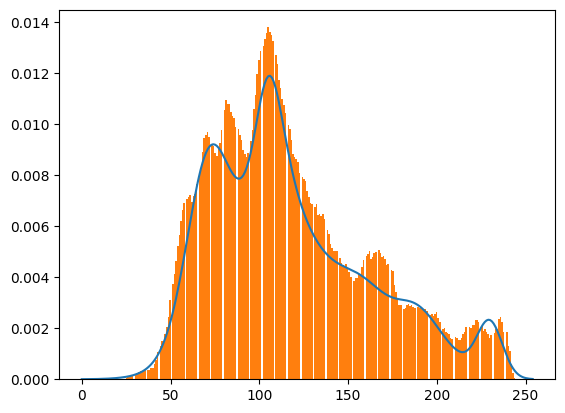

In [73]:

def marginal_density(gmm_means, gmm_covs, gmm_probs, dim_to_keep, points):
    """
    Compute the marginal density of the GMM
    """
    density_values = np.zeros(len(points))
    
    for mean, cov, prob in zip(gmm_means, gmm_covs, gmm_probs):
        mean_marginal = mean[dim_to_keep]
        cov_marginal = cov[np.ix_(dim_to_keep, dim_to_keep)]
        
        marginal_gaussian = scipy.stats.multivariate_normal(mean=mean_marginal, cov=cov_marginal)
        
        # Compute the density for each component
        density_values += prob * marginal_gaussian.pdf(points)
    
    return density_values


density = marginal_density(model.means_, model.covariances_, model.weights_, [1], np.arange(255))
fix,ax = plt.subplots(1,1)
ax.plot(density)
ax.hist(x_pixel[:nb_data_considered,1], bins=255, density=True)
plt.show()